In [1]:
import os
import sys
import seawater as sw
from scipy import interpolate as interp
from functools import partial 

sys.path.append("../scripts")
sys.path.append("../src/iw_model")
sys.path.append("../src/iw_inverse")
sys.path.append("../src/misc")

from iw_invert import InternalWaveInversion
from iw_plots import *
from extract import *
from pseudo_inverse import *


In [2]:
"""
Read data and compute means
"""
path = os.path.join("..","matlab",filename)
table = read_table(path)

#Define a slice of data
DSL = slice(15,80) # depth slice
sl = (slice(0,2000),DSL,slice(0,None),slice(0,None))

#Get state variables
N2 = extract_node(table,'N2')[sl]
#T  = extract_node(table,'T')[sl]
#S  = extract_node(table,'S')[sl]
R  = extract_node(table,'R')[sl]
W  = extract_node(table,'W')[sl]*100
Z  = extract_node(table,'z').flatten()[sl[1]]
depth = extract_node(table,'depth')

TIME   = extract_node(table,'time').flatten()[sl[0]]
DEPTH  = extract_node(table,'z').flatten()[sl[1]]

#Start time at zero
t0 = matlab2datetime(TIME[1]).timestamp()
TIME = [round(matlab2datetime(T).timestamp()-t0) for T in TIME]
X = 1e3*np.arange(0,24,2)
Y = 1e3*np.arange(0,24,2)

#Form a coordinate matrix
AX = np.array(list(itertools.product(*[TIME,DEPTH,X,Y])),dtype=[('t',float),('z',float),('x',float),('y',float)])
AX = AX.reshape(W.shape)

In [3]:
"""
Compute means
"""
#Compute the mean stratification
N2_mean = np.mean(N2,axis=(0,2,3))
R_mean = np.mean(R,axis=(0,2,3))
#T_mean  = np.mean(T,axis=(0,2,3))
#S_mean  = np.mean(S,axis=(0,2,3))


#Create a function that is depth as a function of the mean density
zofr = interp.InterpolatedUnivariateSpline(R_mean,Z)
DZ   = AX['z'] - zofr(R) 

[-2.3988e+01  1.2000e-02  1.2000e-02  1.2000e-02  1.2000e-02  1.2000e-02
  1.2000e-02  1.2000e-02  1.2000e-02  1.2000e-02  1.2000e-02  1.2000e-02]


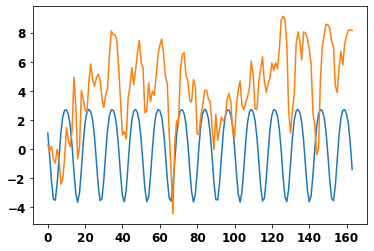

In [4]:
M2 = (1/12.42)*24
def digital_filter(data,target_freqs,fs):
    """
    B.C. hack and chop filter
    Designed for 4D data, time must be first axis of data
    """
    #Find nearest frequency index
    freqs = np.fft.fftfreq(data.shape[0],fs)
    print( np.unique(np.diff(freqs)))
    pos_fi=[]
    neg_fi=[]
    for tf in target_freqs:
       pos_fi.append( np.argmin(abs(freqs-tf)) )
       neg_fi.append( np.argmin(abs(freqs+tf)) )

    #Transform 
    data_hat = np.fft.fft(data,axis=0)
    
    mask = np.zeros(data_hat.shape)
    mask[pos_fi,:,:,:] = 1
    mask[neg_fi,:,:,:] = 1
     
    data_hat = data_hat*mask
    
    return np.fft.ifft(data_hat,axis=0)
     
DZB = digital_filter(DZ,[M2,2*M2],1/24)
DZB=DZB.real

plt.plot(DZB[0:164,0,0,0])
plt.plot(DZ[0:164,0,0,0])


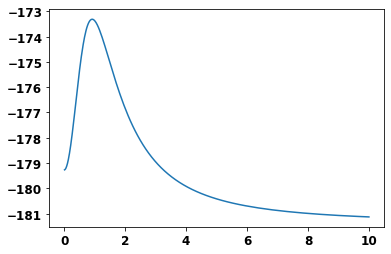

In [5]:
"""
M2 band pass filter
"""
def bandpass_filter(center,half_width,fs,order=6):
    nyq = fs*0.5
    lo = (center-half_width)/nyq
    hi = (center+half_width)/nyq
    b, a = sig.butter(order, [lo, hi], btype='band')
    return b,a

M2  = 1/12.42
bw  = .005
b,a = bandpass_filter(M2,bw,1)
DZB2 = sig.lfilter(b,a,DZ,axis=0)
WB = sig.lfilter(b,a,W,axis=0)

w, h = sig.freqs(b, a)
plt.plot(w, 20 * np.log10(abs(h)))


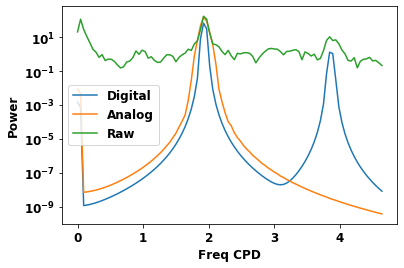

In [6]:
#DZ_AVG = DZB.mean(axis=(1,2,3))
f,pxx = sig.welch(DZB,fs=24,nperseg=512,axis=0)
plt.semilogy(f[:100],pxx[:100,0,0,0],label='Digital')
f,pxx = sig.welch(DZB2,fs=24,nperseg=512,axis=0)
plt.semilogy(f[:100],pxx[:100,0,0,0],label='Analog')
f,pxx = sig.welch(DZ,fs=24,nperseg=512,axis=0)
plt.semilogy(f[:100],pxx[:100,0,0,0],label='Raw')
plt.xlabel('Freq CPD')
plt.ylabel('Power')
plt.plot(2,40)
plt.legend()

Text(0.5, 1.0, 'DZB vs Depth')

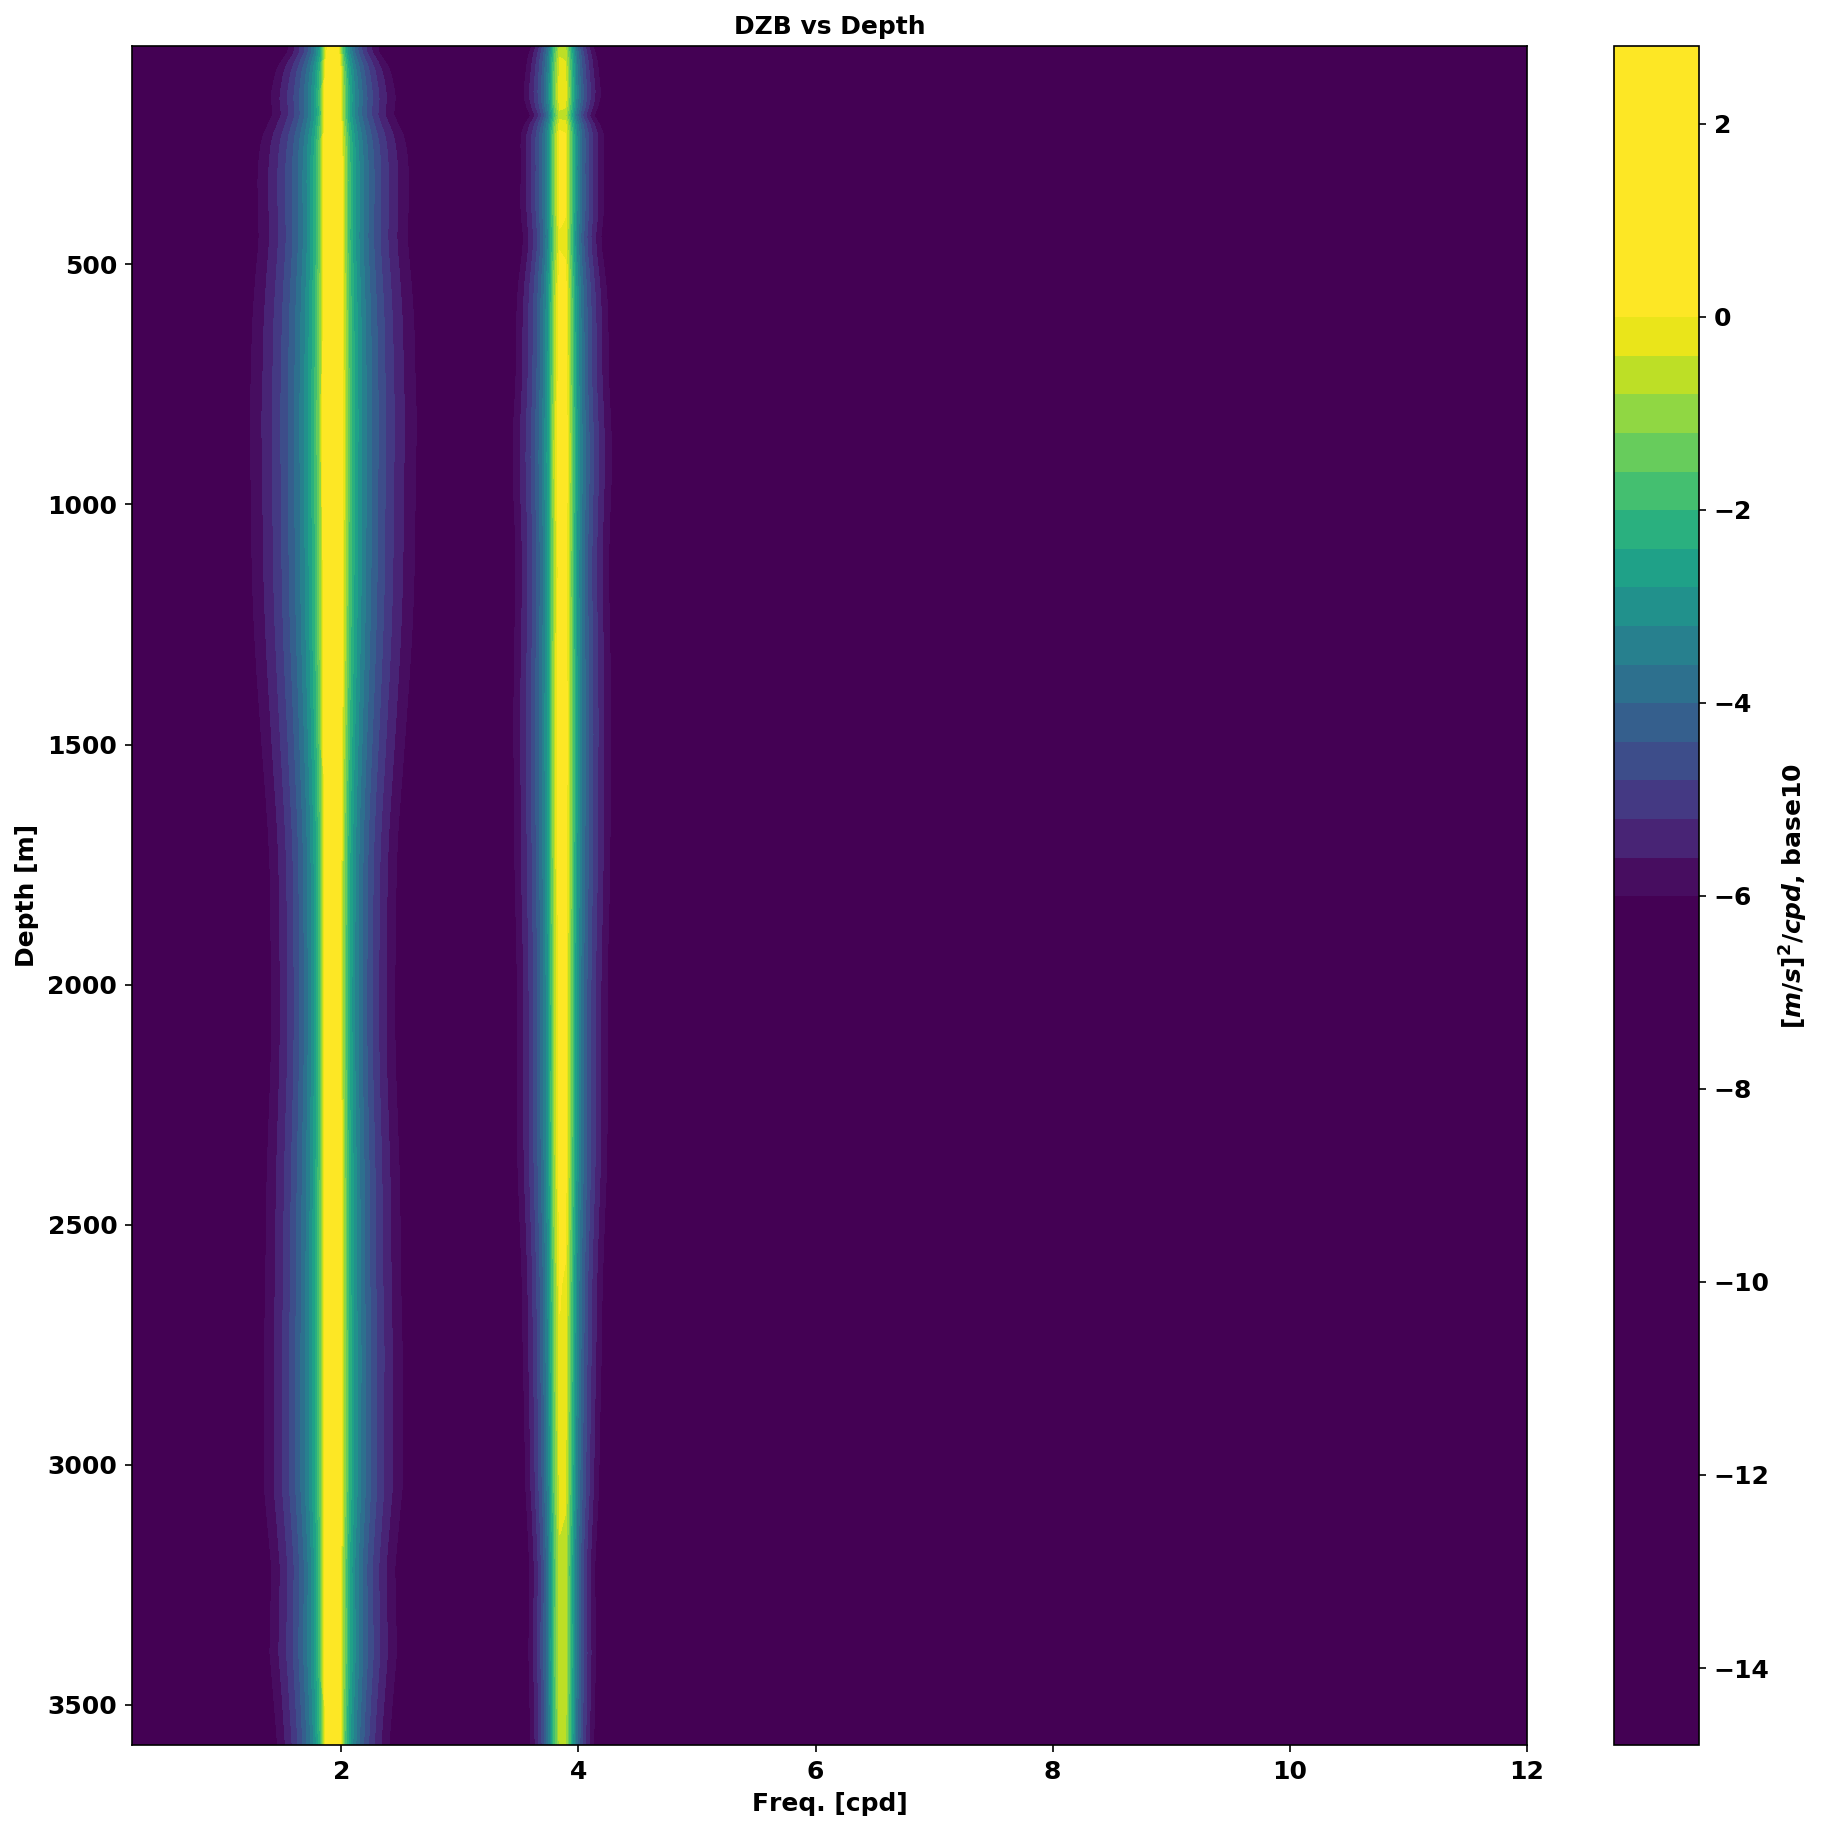

In [7]:
D_AVG = DZB.mean(axis=(2,3))
f, pxx = sig.welch(D_AVG,fs=24,nperseg=512,axis=(0))
plt.figure(figsize=(15,15),dpi=150)
plt.contourf(f[5:],Z[0:80], np.log10(pxx[5:,0:80].T),levels=50)
plt.gca().invert_yaxis()
plt.xlabel('Freq. [cpd]')
plt.ylabel('Depth [m]')
plt.colorbar(label='$[m/s]^2/cpd$, base10')
plt.clim(-6,0)
plt.title('DZB vs Depth')

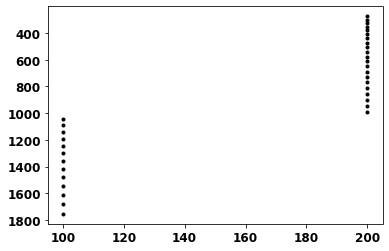

In [8]:

isl = (slice(200,416,1),slice(16,50,1),slice(0,12,1),slice(0,12,1))
#Compute depth variance then apply it to the dataset
R = np.var(DZB, axis=(0,2,3))
R = R[isl[1]]
Zr = AX[0,isl[1],0,0]["z"]
snr = .5
#R = np.array([40- (1-snr)*r if (1-snr)*r > 1 else 1 for r in R])

@np.vectorize
def step_func(z):
    if z > 1000:
        return 100
    else: 
        return 200  

R =  step_func(Zr) #np.var(DZB,axis=(0,2,3))
RofZ = interp.interp1d(Zr,R)
plt.plot(R,Zr,'k.')
plt.gca().invert_yaxis()

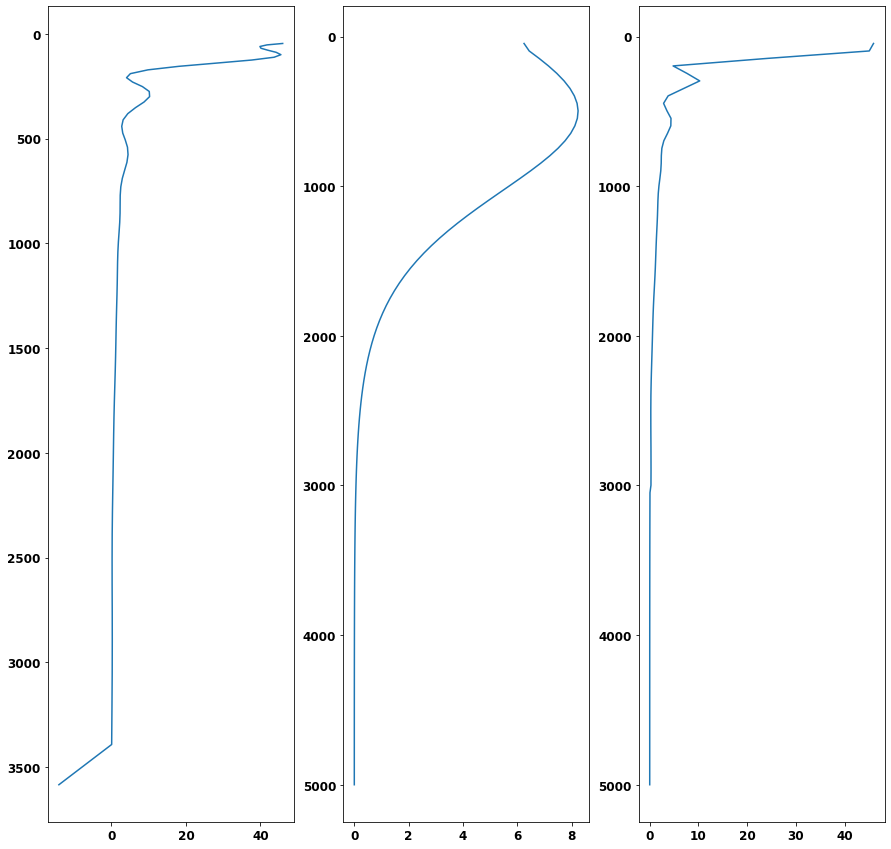

In [9]:
Z_even = np.linspace(Z[0],5000,100)
n2_of_z = interp.interp1d(Z,N2_mean)

def cannonical_bfrq(Z):
    """
    Desc:
    Cannonical example of a mid ocean Brunt Viasala frequency0
    depth profile. Mainly for testing purposes
    """
    d = max(Z)
    diff  = np.average(np.diff(Z))
    sigma = 22 + np.tanh(2*np.pi*(Z- d*.1)/d)
    N2    = 2*np.gradient(sigma,diff)/(2*diff)
    return N2

def mixed_bfrq(Z,ideal,real,depth):
    above = real(Z[np.where(Z<depth)])
    below = ideal(Z)[np.where(Z>depth)]
    return np.concatenate([above,below])


N2F = partial(mixed_bfrq,ideal=cannonical_bfrq,real=n2_of_z,depth=3000)

cph = 3600/(2*np.pi)
f,ax = plt.subplots(1,3)
ax[0].plot(cph**2 * n2_of_z(Z),Z)
ax[1].plot(cph**2 * cannonical_bfrq(Z_even),Z_even)
ax[2].plot(cph**2 * N2F(Z_even),Z_even)
ax[0].invert_yaxis()
ax[1].invert_yaxis()
ax[2].invert_yaxis()
f.set_size_inches(15,15)



In [10]:
"""
Compute Inversion All Data
"""
%load_ext autoreload
%autoreload

M2  = 1/12.42

def make_ps(freqs,modes,thetas,hwvns):
    parr = np.array(list(itertools.product(*[freqs,hwvns,modes,thetas])),
                         dtype=[('f',float),('k',float),('m',int),('theta',float)])
    param_df = pd.DataFrame({'freqs' : parr['f'], 
                             'modes' : parr['m'], 
                             'theta' : parr['theta'],
                             'hwvn'  : parr['k']
                            })
    return param_df

#Inversion slice
#isl = (slice(200,368,2),slice(16,50,1),slice(0,12,1),slice(0,12,1))
isl = (slice(200,272,1),slice(16,50,2),slice(0,12,1),slice(0,12,1))

#Subsample data set create dataframe
cube = pd.DataFrame({"dz"    : DZB[isl].flatten(),
                     "time"  : AX[isl]["t"].flatten(),
                     "z"     : AX[isl]["z"].flatten(),
                     "x"     : AX[isl]["x"].flatten(),
                     "y"     : AX[isl]["y"].flatten()
                    })

cube['date'] = pd.to_datetime(cube['time'] + t0, unit='s')
cube['RINV'] = 1/RofZ(cube['z'])

si = .8
split_time = (max(cube.time)-min(cube.time))*si + min(cube.time)
train= cube[cube.time < split_time]
test = cube[cube.time > split_time]

#Set up regular internal wave model
FREQS = [M2/3600,2*M2/3600]
ANGLES  = np.arange(0,360,5)
MODES = np.arange(0,8)
iwi = InternalWaveInversion(train,FREQS,MODES,ANGLES,Z_even,N2F(Z_even,),tc='dz',mean=False)

#Set up parameter space for M2 mode 1 
#ANGLES  = np.arange(0,360,5)
#HWVN = list(1e-3/np.linspace(120,140,10))
#MODES = np.arange(0,1)
#ps_m2m1 = make_ps(FREQS,MODES,ANGLES,HWVN)

###Set up parameter space for M2 mode 2 
#HWVN = list(1e-3/np.linspace(80,60,10))
#MODES = np.arange(2,3)
#ANGLES  = np.arange(0,360,5)
#ps_m2m2 = make_ps(FREQS,MODES,ANGLES,HWVN)

###Set up parameter space for M2 mode 2 
#HWVN = list(1e-3/np.linspace(60,40,10))
#MODES = np.arange(2,3)
#ANGLES  = np.arange(0,360,5)
#ps_m2m3 = make_ps(FREQS,MODES,ANGLES,HWVN)

#iwi.update_params(ps_m2m1)
#iwi.update_params(ps_m2m2)
#iwi.update_params(ps_m2m3)

#Run inversion
#iwi.ps['QINV'] = (iwi.ps['modes'] + 10)**2# np.ones(len(iwi.ps))
iwi.ps['QINV'] = (10)**2# np.ones(len(iwi.ps))
iwi.pinvert()

[2.50953173+0.j 1.31912161+0.j 0.9094088 +0.j 0.67010629+0.j]
[2.50900937+0.j 1.31882725+0.j 0.90913889+0.j 0.66981428+0.j]


In [11]:
M=iwi.H.shape[0]
N=iwi.H.shape[1]
Ri = np.diag(train['RINV'])
Q  = np.diag(np.concatenate([ (1/iwi.ps['QINV']), (1/iwi.ps['QINV']) ] ) )

#pQ = ( np.eye(N) - Q @ iwi.H.T @ Ri @ (np.eye(M) - iwi.H @ iwi.hdag) @ iwi.H ) @ Q


MemoryError: Unable to allocate array with shape (139536, 139536) and data type float64

In [ ]:
print( 100*(np.trace(  Q ) - np.trace ( pQ ) )/ np.trace(Q)  )
print(np.trace(Q))

In [ ]:
w,v = np.linalg.eig(pQ)
vp = v[:,np.argsort(w)[::-1]]
x = np.arange(0,360,5)
plt.plot(x,vp[:72,0],'b.')
plt.plot(x,vp[72:144,0],'r.')
plt.plot(x,vp[144:216,0],'g.')
plt.grid(True)

In [ ]:
len(vp[:,0])
x = iwi.H @ vp[:,0]

plt.plot(x)

In [ ]:
plt.plot(1/iwi.ps.QINV.unique(),'k.')

In [ ]:
plt.plot(np.sort(1e-3/iwi.ps.hwvn.unique()[1:]),'k.')

In [ ]:

1e-3/iwi.ps.hwvn.unique()[0:]

In [27]:
1e-3/iwi.ps[iwi.ps.theta==0].hwvn

0       131.259033+0.000000j
72       68.995592+0.000000j
144      47.565894+0.000000j
216      35.049369+0.000000j
288      27.930796+0.000000j
360      22.721786+0.000000j
432      20.191846+0.000000j
504      17.732638+0.000000j
576      58.080144+0.000000j
648      30.529052+0.000000j
720      21.045325+0.000000j
792      15.505287+0.000000j
864      12.356088+0.000000j
936      10.051501+0.000000j
1008      8.934913+0.000000j
1080      7.844228+0.000000j
Name: hwvn, dtype: complex128

In [38]:
#Compute an estimate
%autoreload
#forecast_df = cube[cube['time'] >= 0.8*max(cube['time'])]
delta = int(1e4)
j = delta
cube['dz'] = DZ[isl].flatten()
cube['dz_hat'] = 0
for i in np.arange(0,len(cube),delta):
    cube.loc[i:j,['dz_hat']] = iwi.estimate(ds=cube.loc[i:j])
    j= j + delta

cube['err']    = cube['dz_hat'] - cube['dz']


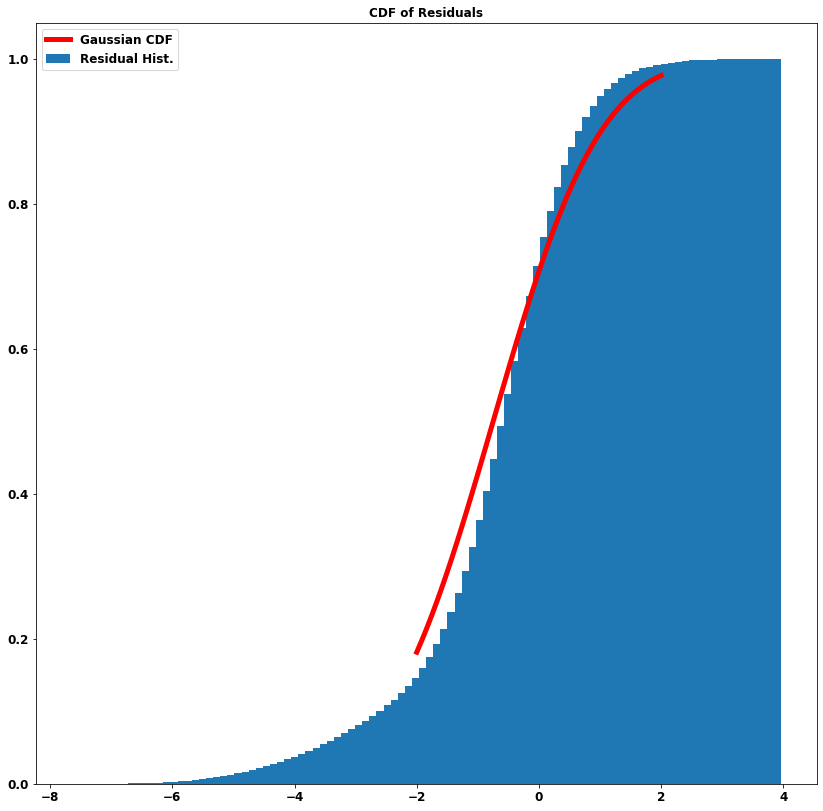

In [39]:
from scipy import stats
f , ax =plt.subplots()
x = np.linspace(-2,2)
errors = cube['err']/np.sqrt(RofZ(cube['z']))
h = ax.hist(errors,bins=100,density=True,cumulative=True,label='Residual Hist.')
ax.plot(x,stats.norm.cdf(x,np.mean(errors),np.sqrt(np.var(errors))),'r',linewidth=5,label='Gaussian CDF')
ax.set_title('CDF of Residuals')
ax.legend()
f.set_size_inches(14,14)

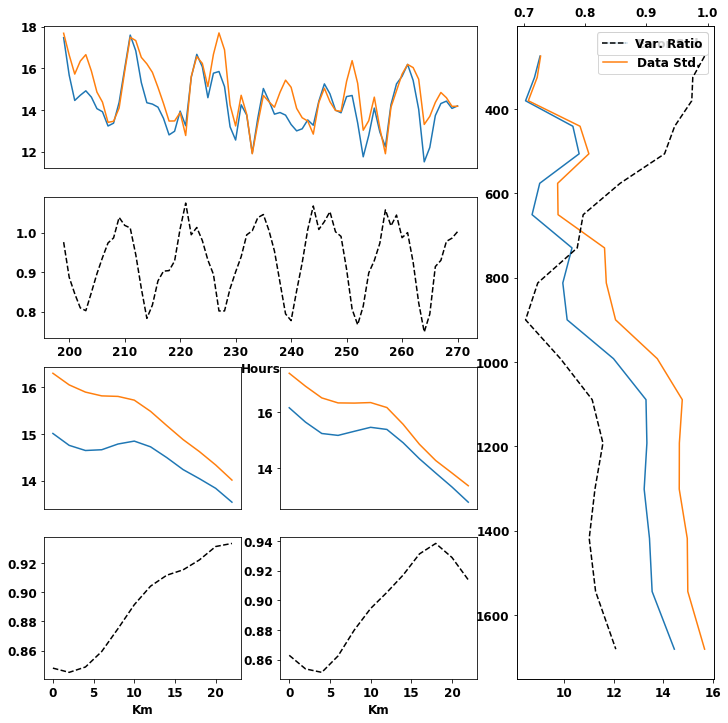

In [41]:
"""
Plot error variance across each exis
"""
%autoreload

DZH = cube['dz_hat'].values.reshape(DZ[isl].shape)
ERR = (DZH-DZ[isl])
VAL = DZ[isl]

f=plt.figure()
plot_error_variance(f,ERR,VAL,AX,isl)
f.set_size_inches(12,12)

In [15]:
np.sqrt(DZ[2,:,:,:].flatten().T @ DZ[2,:,:,:].flatten())

3207.784805135149

(72, 17, 12, 12)


Text(0.5, 1.0, ' Residuals vs Depth')

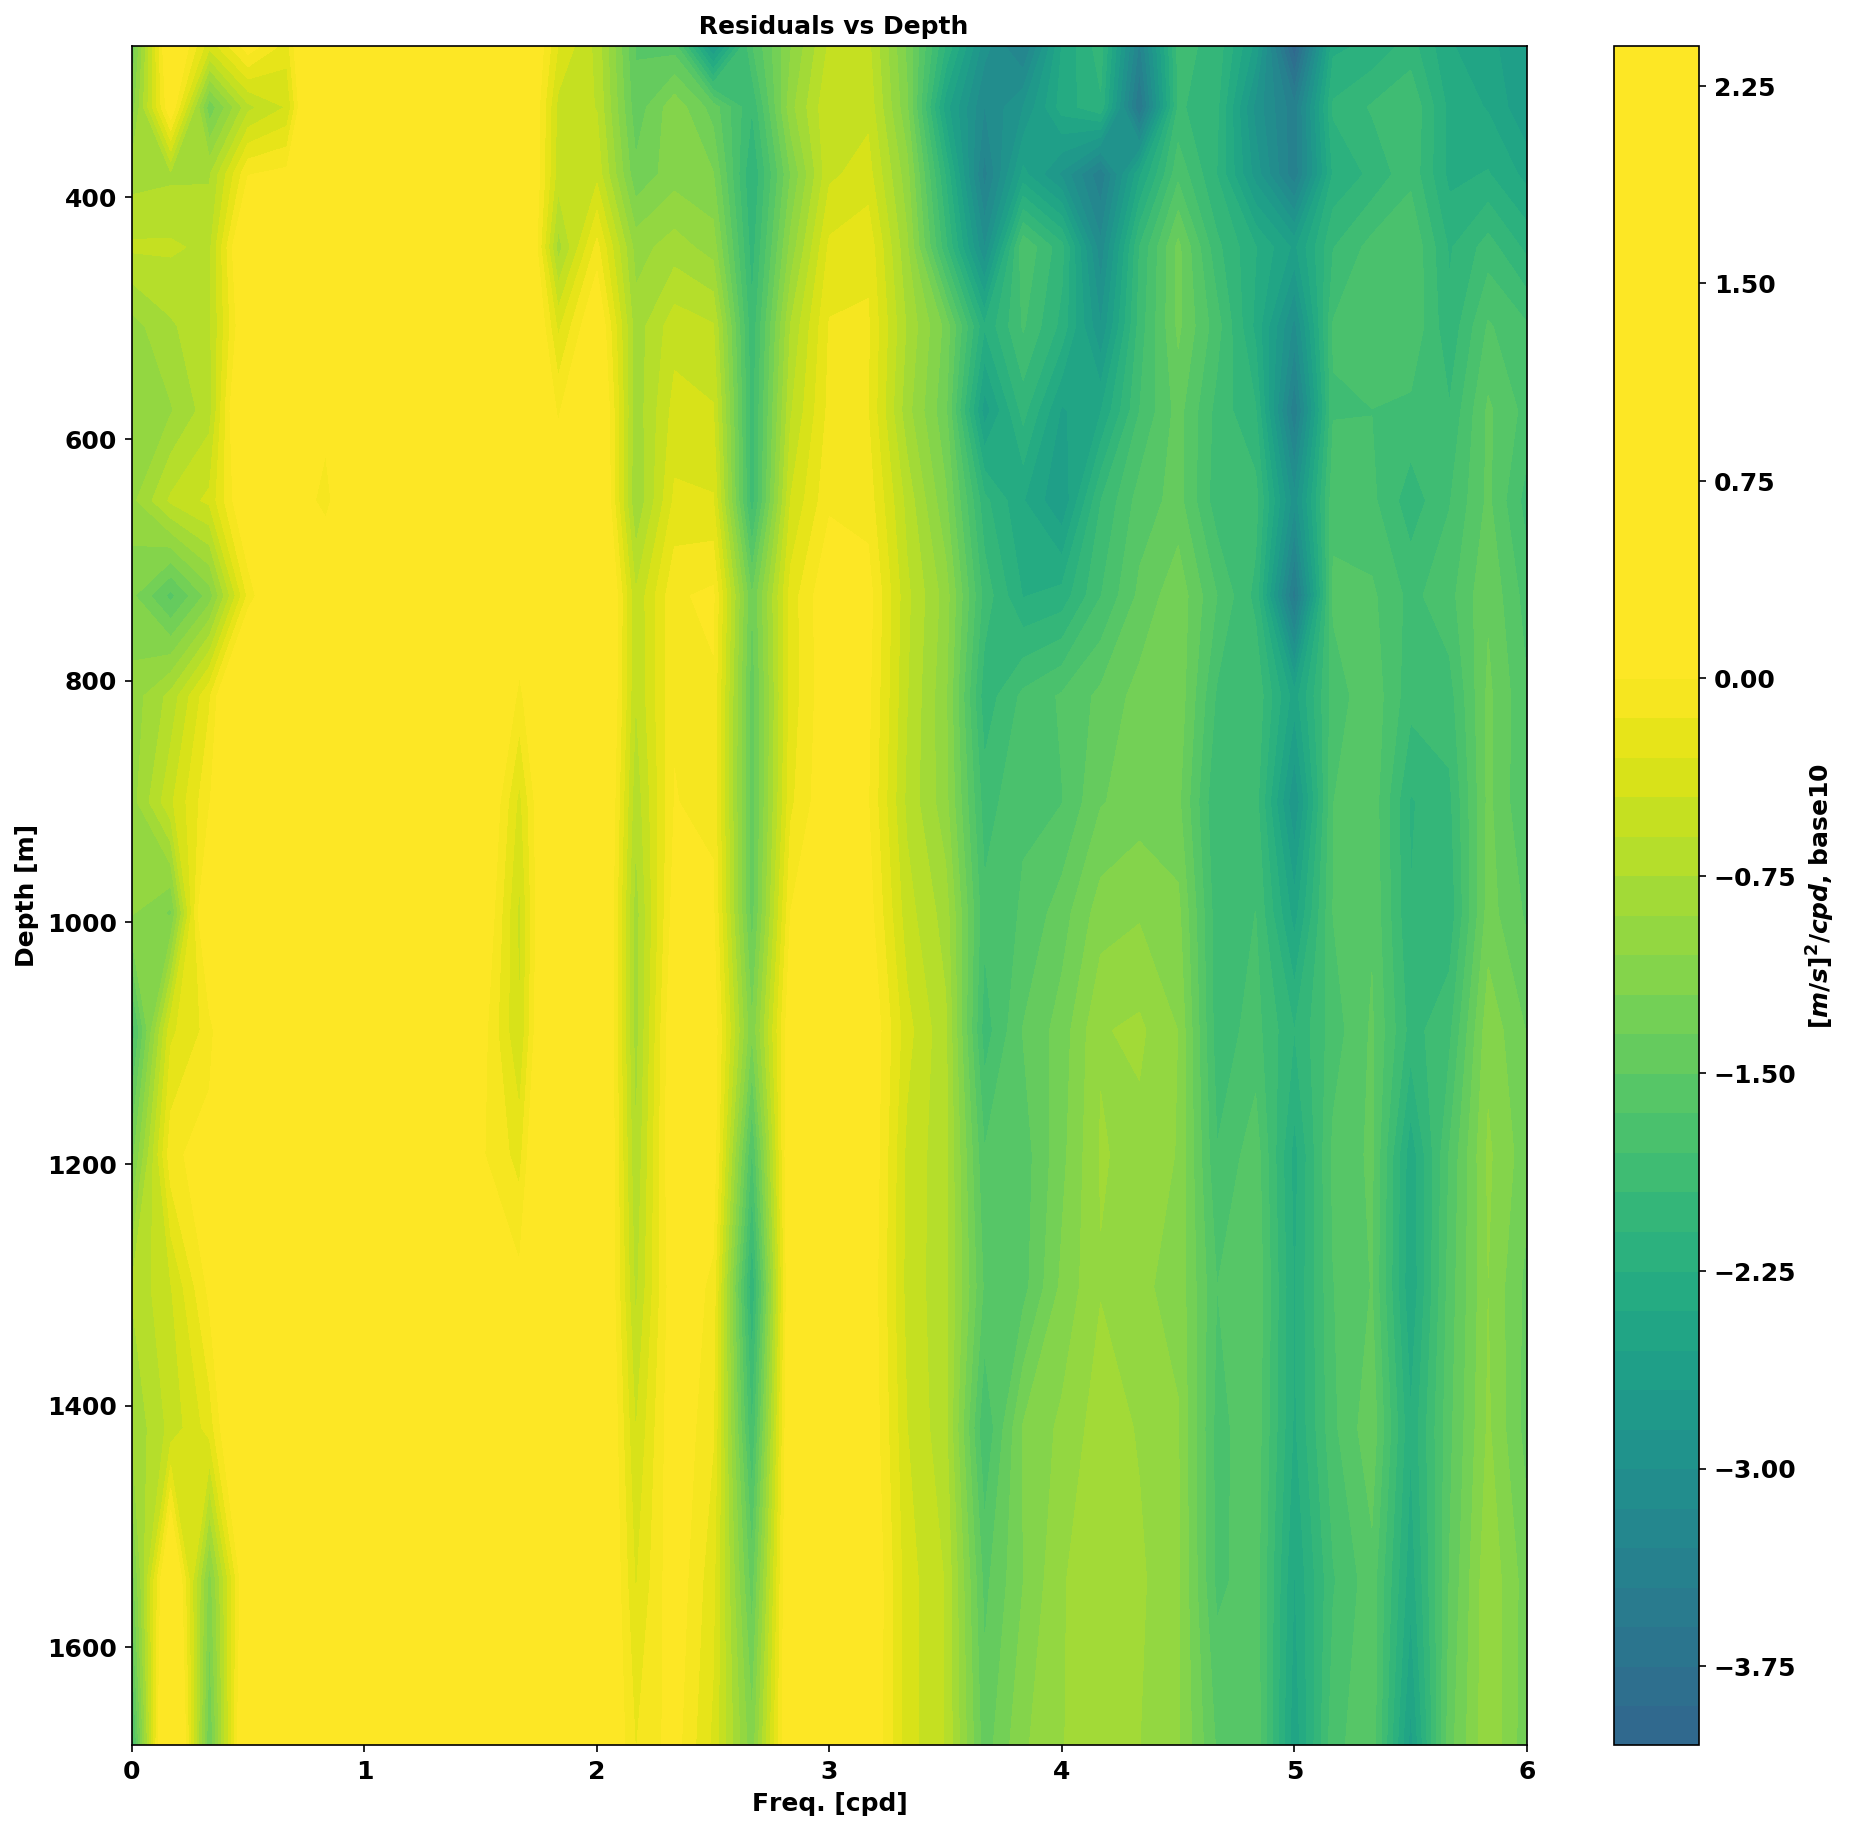

In [44]:
print(ERR.shape)
f, pxx = sig.welch(ERR.mean(axis=(2,3)),fs=24/2,nperseg=512,axis=(0))
plt.figure(figsize=(15,15),dpi=150)
plt.contourf(f,AX[0,isl[1],0,0]['z'], np.log10(pxx.T),levels=50)
plt.gca().invert_yaxis()
plt.xlabel('Freq. [cpd]')
plt.ylabel('Depth [m]')
plt.colorbar(label='$[m/s]^2/cpd$, base10')
plt.clim(-6,0)
plt.title(' Residuals vs Depth')

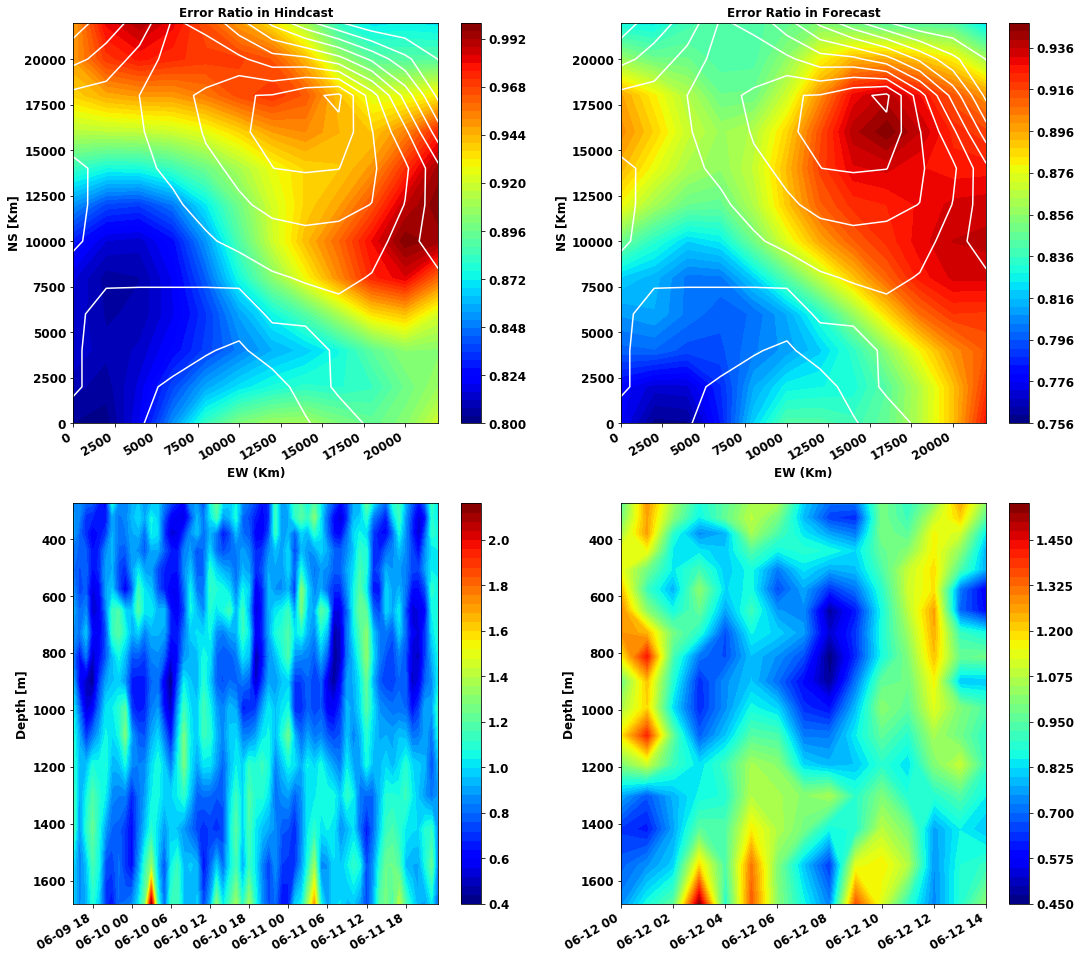

In [42]:
%autoreload
train= cube[cube.time < split_time]
test = cube[cube.time > split_time]

#Error ratio lat lon
latlon_test = test.groupby(['x','y']).var().reset_index()
latlon_test['r'] = (latlon_test['err']/latlon_test['dz'])


#Error ratio lat lon
latlon_train = train.groupby(['x','y']).var().reset_index()
latlon_train['r'] = (latlon_train['err']/latlon_train['dz'])

#Error ratio depth
depthtime_test = test.groupby(['date','z']).var().reset_index()
depthtime_test['r'] = (depthtime_test['err']/depthtime_test['dz'])

#Error ratio depth
depthtime_train = train.groupby(['date','z']).var().reset_index()
depthtime_train['r'] = (depthtime_train['err']/depthtime_train['dz'])


f,ax=plt.subplots(2,2)
p1 = plot_dataframe_slice(latlon_train,'x','y','r',ax[0,0],cmap='jet',levels=50)
ax[0,0].contour(X,Y,depth,levels=10,colors='w')
ax[0,1].contour(X,Y,depth,levels=10,colors='w')
p2 = plot_dataframe_slice(latlon_test,'x','y','r',ax[0,1],cmap='jet',levels=50)
p3 = plot_dataframe_slice(depthtime_train,'date','z','r',ax[1,0],cmap='jet',levels=50)
p4 = plot_dataframe_slice(depthtime_test,'date','z','r',ax[1,1],cmap='jet',levels=50)



ax[1,0].invert_yaxis()
ax[1,1].invert_yaxis()
ax[0,0].set_title('Error Ratio in Hindcast')
ax[0,1].set_title('Error Ratio in Forecast')
ax[0,0].set_ylabel('NS [Km]')
ax[0,1].set_ylabel('NS [Km]')
ax[0,1].set_xlabel('EW (Km)')
ax[0,0].set_xlabel('EW (Km)')
ax[1,0].set_ylabel('Depth [m]')
ax[1,1].set_ylabel('Depth [m]')

f.colorbar(p1,ax=ax[0,0])
f.colorbar(p2,ax=ax[0,1])
f.colorbar(p3,ax=ax[1,0])
f.colorbar(p4,ax=ax[1,1])
f.autofmt_xdate()
f.set_size_inches(18,18)

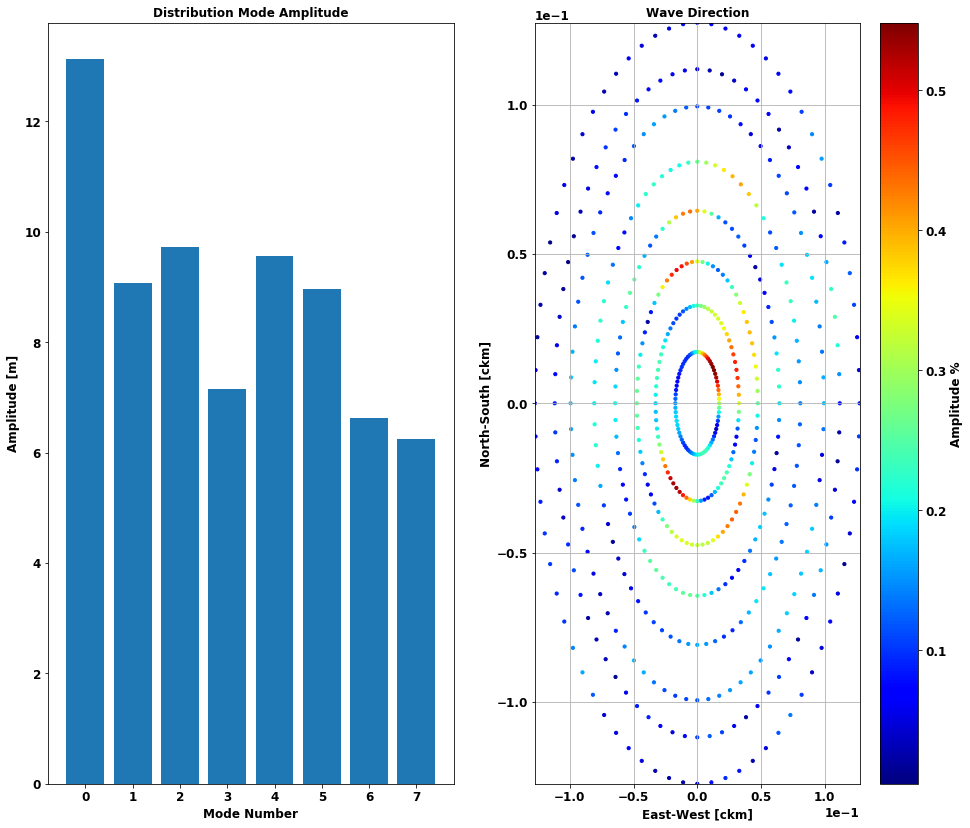

In [45]:
"""
Plotting Parameter space
"""
f,(ax1,ax2) =plt.subplots(1,2)
from iw_plots import *
%autoreload
mode_amplitude(ax1,iwi.ps)
p = k_space_magnitude(ax2,iwi.ps,8,1)
R1 = 1/130
t = np.linspace(0,2*np.pi)
#ax2.plot(R1*np.cos(t),R1*np.sin(t),'k-')
f.colorbar(p,label="Amplitude %")
f.set_size_inches(16,14)

In [ ]:
mode_plot(iwi.iwmodes[0],3)

In [ ]:
%autoreload
import iw_plots as iwp
"""
Plotting Forecasts
"""
xu = cube['x'].unique()
yu = cube['x'].unique()

line = cube[(cube["x"]==xu[2]) & (cube["y"]==yu[2])]
f, ax = plt.subplots(4,1,sharex=True)
cnorm = (-35,0,35)
p1 = iwp.plot_dataframe_slice(line[line['time'] < split_time],'date','z','dz',ax[0],cnorm=(cnorm),invert=True)
p2 = iwp.plot_dataframe_slice(line,'date','z','dz_hat',ax[1],cnorm=(cnorm),invert=True)
p3 = iwp.plot_dataframe_slice(line,'date','z','dz',ax[2],cnorm=(cnorm),invert=True)
p4 = iwp.plot_dataframe_slice(line,'date','z','err',ax[3],cnorm=(cnorm),invert=True)
ax[0].set_title('Partial Record')
ax[1].set_title('Estimate')
ax[2].set_title('Full Record')
ax[3].set_title('Error')

for a in ax:
    a.set_ylabel('Depth (m)')
f.autofmt_xdate(rotation=70)
cax1 = f.add_axes([.91, 0.72, 0.02, 0.15])
cax2 = f.add_axes([.91, 0.55, 0.02, 0.15])
cax3 = f.add_axes([.91, 0.37, 0.02, 0.15])
cax4 = f.add_axes([.91, 0.2, 0.02, 0.15])
f.colorbar(p1,cax=cax1,label="Displacment (m)")
f.colorbar(p2,cax=cax2,label="Displacment (m)")
f.colorbar(p3,cax=cax3,label="Displacment (m)")
f.colorbar(p3,cax=cax4,label="Displacment (m)")
f.set_size_inches(15,15)

In [ ]:
import matplotlib.animation as animation
from IPython.display import HTML
"""
Animation of 500 meter depth displacment
"""
zu = np.unique(cube['z'])
du = np.unique(cube['time'])
lu = np.unique(cube['y'])


fig,ax = plt.subplots()
di = 6
top = cube[(cube["time"]==du[0]) & (cube["z"]==zu[di]) & (cube["y"]==lu[2])]
p1, = ax.plot(top['x'].values,top['dz_hat'].values,'b.-',label='Est.')
p2, = ax.plot(top['x'].values,top['dz'].values,'r.-',label='True')
ax.legend()
ax.set_title('Isopyncal @ %.2f' % zu[di])
ax.set_ylim(-20,20)

def update(frame):
    top = cube[(cube["time"]==du[frame]) & (cube["z"]==zu[di]) & (cube["y"]==lu[2])]
    p1.set_data(top['x'].values,top['dz_hat'].values)
    p2.set_data(top['x'].values,top['dz'].values)
    return p,
    

#Compile Animation
ani = animation.FuncAnimation(fig, update,frames=np.arange(0,40,1),blit=False)

HTML(ani.to_html5_video())
##ani.save("foo.mp4")


In [ ]:
"""
Animation of 500 meter depth displacment
"""
zu = np.unique(cube['z'])
du = np.unique(cube['time'])
lu = np.unique(cube['y'])
di = 6
layer = cube[(cube["time"]==du[0]) & (cube["z"]==zu[di])]


fig,ax = plt.subplots(1,2,sharey=True)
p1 = plot_dataframe_slice(layer,'x','y','dz_hat',ax[0],cmap='seismic',levels=50,cnorm=(-10,0,10))
p2  = plot_dataframe_slice(layer,'x','y','dz',ax[1],cmap='seismic',levels=50,cnorm=(-10,0,10))

#ax.legend()
ax[0].set_title('Estimate Isopyncal @ %.2f' % zu[di])
ax[1].set_title('True Isopyncal @ %.2f' % zu[di])
timelabel = ax[0].text(0.9,0.9, "", transform=ax[0].transAxes, ha="right")
#ax.set_ylim(-20,20)
fig.colorbar(p1,ax=ax[0])
fig.colorbar(p2,ax=ax[1])
fig.set_size_inches(16,12)
def update(frame):
    layer = cube[(cube["time"]==du[frame]) & (cube["z"]==zu[di]) ]
    #p1.set_data(top['x'].values,top['dz_hat'].values)
    #p2.set_data(top['x'].values,top['dz'].values)
    p1  = plot_dataframe_slice(layer,'x','y','dz_hat',ax[0],cmap='seismic',levels=50,cnorm=(-10,0,10))
    p2  = plot_dataframe_slice(layer,'x','y','dz',ax[1],cmap='seismic',levels=50,cnorm=(-10,0,10))
    timelabel.set_text("Hous %d" % ( du[frame]/3600 ) )
    return p1, p2
    

#Compile Animation
ani = animation.FuncAnimation(fig, update,frames=np.arange(0,10,1),interval=500,blit=False)

HTML(ani.to_html5_video())
##ani.save("foo.mp4")